In [5]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
from models import ResNet38, Cnn14_16k
import datasets.mvtec as mvtec
import DCASE2021_task2

# CONFIG
import yaml
import os

with open("./config.yaml", 'rb') as f:
    CONFIG = yaml.load(f)

# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')


def parse_args():
    parser = argparse.ArgumentParser('PaDiM')
    parser.add_argument('--data_path', type=str, default='D:/dataset/mvtec_anomaly_detection')
    parser.add_argument('--save_path', type=str, default='./mvtec_result')
    parser.add_argument('--arch', type=str, choices=['resnet18', 'wide_resnet50_2'], default='wide_resnet50_2')
    return parser.parse_args()

def zscore(x, dim = None):
    xmean = x.mean(dim=dim, keepdims=True)
    xstd  = torch.std(x, dim=dim, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore



#def plot_fig(test_img, scores, gts, threshold, save_dir, class_name):
def plot_fig(test_img, scores, save_dir, class_name, wav_names):
    num = len(scores)
    vmax = scores.max()
    vmin = scores.min()
    for i in tqdm(range(num), '| plot heatmap | test | %s |' % class_name):
        img = test_img[i].squeeze()
        #img = denormalization(img)
        #gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i]# * 255
        fig_img, ax_img = plt.subplots(1, 2, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        # vmin, vmaxをスペクトログラムの場合変えるべきか？
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        # show test_img
        ax_img[0].imshow(img.T)
        ax_img[0].title.set_text('Image')
        ax = ax_img[1].imshow(heat_map.T, cmap='jet', norm=norm)
        ax_img[1].imshow(img.T, cmap='gray', interpolation='none')
        ax_img[1].imshow(heat_map.T, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[1].title.set_text('Predicted heat map')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)
        wav_name = os.path.splitext(os.path.basename(wav_names[i]))[0]
        fig_img.savefig(os.path.join(save_dir, wav_name + '.png'), dpi=100)
        plt.close()

# これはMVtech用なので作り直す必要あり
# normalizationしているのでそれをなおしてる
# plot figで使う
# つかわない？
#def denormalization(x):
#    mean = np.array([0.485, 0.456, 0.406])
#    std = np.array([0.229, 0.224, 0.225])
#    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    
#    return x

# パッチごとのlayer1,2,3特徴量
# むずい
def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).cuda()
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    
    return z

<ipython-input-5-77602f9e8bf7>:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  CONFIG = yaml.load(f)


In [9]:
def main():
    ##########################################################
    # load model
    # 36行目のところでモデル選択
    # resnet18 or wide_resnet50_2を使う -> 読み込み
    arch = CONFIG['param']['arch']
    model = ResNet38(sample_rate=CONFIG['param']['sample_rate'],
                     window_size=CONFIG['param']['window_size'],
                     hop_size=CONFIG['param']['hop_size'],
                     mel_bins=CONFIG['param']['mel_bins'],
                     fmin=CONFIG['param']['fmin'],
                     fmax=CONFIG['param']['fmax'],
                     classes_num=527,) # なんでもいい
    pretrained_dict = torch.load(CONFIG['IO_OPTION']['PREMODEL_ROOT'])
    
    model.load_state_dict(pretrained_dict['model'], strict=True)
    
    t_d = 128    # 全特徴量(64+128+256=448)
    d = 128     # 使う特徴量数
    ##########################################################
    model.to(device)
    model.eval()
    ##########################################################
    ###### seed ##############################################
    random.seed(1024)
    torch.manual_seed(1024)
    if use_cuda:
        torch.cuda.manual_seed_all(1024)
    ##########################################################
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    ##########################################################
    # set model's intermediate outputs########################
    # モデルの中間出力の設定
    outputs = []
    # hook functionで中間出力をappendする
    def hook(module, input, output):
        # (Batch, Ch, Time, Mel)
        B, C, T, M = output.size()
        output = output.view(B*C, T, M)
        output = torch.bmm(output.transpose(1, 2), output, out=None)
        output = output.view(B, C, M, M)
        outputs.append(output)
    
    #model.resnet.layer1[-1].register_forward_hook(hook)
    model.resnet.layer2[-1].register_forward_hook(hook)
    #model.resnet.layer3[-1].register_forward_hook(hook)
    #model.resnet.layer4[-1].register_forward_hook(hook)
    
    # for test
    inputs = []
    def in_hook(module, input, output):
        inputs.append(output)
    
    ###########################################################
    # outputフォルダ作成
    ###########################################################
    os.makedirs(os.path.join(CONFIG['IO_OPTION']['OUTPUT_ROOT'], 'temp_%s' % arch), exist_ok=True)
    ###########################################################
    # 定義
    ###########################################################
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig_img_rocauc = ax[0]
    fig_pixel_rocauc = ax[1]

    total_roc_auc = []
    total_pixel_roc_auc = []
    ###########################################################
    # 抽出
    ###########################################################
    # データタイプごとにループ
    for class_name in DCASE2021_task2.CLASS_NAMES:
        # データセット/データローダ作成、
        # is_train = phase に変える
        train_dataset = DCASE2021_task2.DCASE2021_task2_Dataset(CONFIG['IO_OPTION']['INPUT_ROOT'], class_name=class_name, phase='train')
        train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['param']['batch_size'], num_workers=2, pin_memory=True)
        test_dataset = DCASE2021_task2.DCASE2021_task2_Dataset(CONFIG['IO_OPTION']['INPUT_ROOT'], class_name=class_name, phase='test')
        test_dataloader = DataLoader(test_dataset, batch_size=CONFIG['param']['batch_size'], num_workers=2, pin_memory=True)
        # それぞれのレイヤをdictで管理
        # OrderedDict -> 追加された順番がわかるdict
        #train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
        #test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
        train_outputs = OrderedDict([('layer2', [])])
        test_outputs = OrderedDict([('layer2', [])])
        # extract train set features (trainの特徴抽出)
        train_feature_filepath = os.path.join(CONFIG['IO_OPTION']['OUTPUT_ROOT'], 'temp_%s' % arch, 'train_%s.pkl' % class_name)
        ############################################# 学習フェーズ #################################################
        # 既に学習がおわっているかどうかをtrain pathをみて判断する(なければ実行)
        if not os.path.exists(train_feature_filepath):
            num_iter = 0
            for (x, _, _) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
                # model prediction
                with torch.no_grad():
                    _ = model(x.to(device))
                # get intermediate layer outputs(中間層出力の取得)
                # 中間出力をappend
                # key = 'layer1'... value = 値
                # get intermediate layer outputs
                for k, v in zip(train_outputs.keys(), outputs):
                    v = v.cpu().detach()
                    if num_iter == 0:
                        train_outputs[k] = v
                    else:
                        train_outputs[k] = torch.cat([train_outputs[k], v], 0)
                num_iter = 1
                # initialize hook outputs
                outputs = []
            # key = 'layer1'... value = 値
            # appendされていたやつをcat
            # train_outputs[k] = (n_sample, Ch, H, W)
            #for k, v in train_outputs.items():
            #    train_outputs[k] = torch.cat(v, 0)

            # Embedding concat
            # embedding_concatを使ってパッチごとに特徴を集める
            # layer1を起点にlayer2,layer3の対応する部分を集めてると思われる
            embedding_vectors = train_outputs.pop('layer2')
            #for layer_name in ['layer2', 'layer3']:
            #    embedding_vectors = embedding_concat(embedding_vectors, train_outputs.pop(layer_name))
            #    # del train_outputs
            #    train_outputs[layer_name] = []
            # randomly select d dimension(d次元をランダムに選択)
            # torch.index_select (https://pytorch.org/docs/stable/generated/torch.index_select.html)
            # embedding_vectorsのdim1に沿ってindices = [0,2,4](idx)を取得（サンプルを取得してる)
            # 0~t_d idxの中からランダムにd個サンプリングする
            embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
            print(embedding_vectors.shape)
            #torch.Size([6018, 128, 250, 16])
            ####################### calculate multivariate Gaussian distribution (MVG計算)##########################
            # PaDiMではパッチごとにMVGを作成する
            #print(embedding_vectors.size())
            B, C, H, W = embedding_vectors.size()
            embedding_vectors = embedding_vectors.view(B, C, H * W)
            mean = torch.mean(embedding_vectors, dim=0).numpy()
            cov = torch.zeros(C, C, H * W).numpy()
            I = np.identity(C)
            # パッチごとにMVG
            for i in tqdm(range(H * W), '| calc MVG | train | %s |' % class_name):
                #cov[:, :, i] = LedoitWolf().fit(embedding_vectors[:, :, i].numpy()).covariance_
                cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
            # save learned distribution (保存)
            train_outputs = [mean, cov]
            with open(train_feature_filepath, 'wb') as f:
                pickle.dump(train_outputs, f)
            ########################################################################################################
        else:
            # すでにtrain pathがあるならロード
            print('load train set feature from: %s' % train_feature_filepath)
            with open(train_feature_filepath, 'rb') as f:
                train_outputs = pickle.load(f)
        ############################################################################################################
        ############################################# 推論フェーズ #################################################
        
        # 異常部位のground truthがあれば使う（こんかいはつかわない）
        gt_list = []
        #gt_mask_list = []
        test_imgs = []
        wav_names = []
        model.logmel_extractor.register_forward_hook(in_hook)
        # extract test set features (trainのときと一緒)##################################################
        for (x, y, wav_name) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
            #test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            #gt_mask_list.extend(mask.cpu().detach().numpy())
            # model prediction
            with torch.no_grad():
                _ = model(x.to(device))
            test_imgs.extend(inputs[0].cpu().detach().numpy())
            # get intermediate layer outputs
            for k, v in zip(test_outputs.keys(), outputs):
                v = v.cpu().detach()
                test_outputs[k].append(v.cpu().detach())
            wav_names.extend(wav_name)
            # initialize hook outputs
            outputs = []
            inputs = []

        for k, v in test_outputs.items():
            test_outputs[k] = torch.cat(v, 0)
        
        # Embedding concat
        embedding_vectors = test_outputs['layer2']
        #for layer_name in ['layer2', 'layer3']:
        #    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])
        # 時間方向にmeanをしてしまえば、位置情報をきにしなくて良さそう
        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
        #######################################　マハラノビス距離計算　###############################################
        # calculate distance matrix
        
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
        dist_list = []
        # 対応するMVGを取り出してマハラノビス距離を計算(H*W個のMVGがある、特徴量はC)
        # 一つのMVGを取り出した際には、サンプルすべての対応するパッチMVGとのマハラノビス距離を計算する。
        for i in tqdm(range(H * W), '| calc mahalanobis | test | %s |' % class_name):
            mean = train_outputs[0][:, i]
            conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
            dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
            dist_list.append(dist)
        
        # 最終的に(B,H,W)の異常スコアマップが出力される
        dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

        # upsample(リサイズしたやつをもとにもどす)　# わからん
        dist_list = torch.tensor(dist_list)
        score_map = dist_list.unsqueeze(1).squeeze().numpy()
        # わからん(ノイズ除去？)
        # apply gaussian smoothing on the score map(スコアマップにガウシアン・スムージングを適用する)
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)
        
        # なんでやるかわからん
        # Normalization
        max_score = score_map.max()
        min_score = score_map.min()
        scores = (score_map - min_score) / (max_score - min_score) # おそらくこれを可視化すればよい（異常部位）
        
        ####################################### 評価 ######################################
        # calculate image-level ROC AUC score
        # 最大値を異常スコアにする
        img_scores = scores.reshape(scores.shape[0], -1).mean(axis=1)
        gt_list = np.asarray(gt_list)
        fpr, tpr, _ = roc_curve(gt_list, img_scores)
        img_roc_auc = roc_auc_score(gt_list, img_scores)
        total_roc_auc.append(img_roc_auc)
        print('image ROCAUC: %.3f' % (img_roc_auc))
        fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))
        ###################################################################################
        
        ######################################### やらない（？）####################################################
        # get optimal threshold(最適な閾値を得る) 
        #gt_mask = np.asarray(gt_mask_list)
        #precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
        #a = 2 * precision * recall
        #b = precision + recall
        #f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        #threshold = thresholds[np.argmax(f1)]

        # calculate per-pixel level ROCAUC(ピクセル単位のROCAUCを算出)
        #fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
        #per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
        #total_pixel_roc_auc.append(per_pixel_rocauc)
        #print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

        #fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
        save_dir = CONFIG['IO_OPTION']['OUTPUT_ROOT'] + '/' + f'pictures_{arch}'
        os.makedirs(save_dir, exist_ok=True)
        #plot_fig(test_imgs, scores, gt_mask_list, threshold, save_dir, class_name)
        plot_fig(test_imgs, scores, save_dir, class_name, wav_names)

        ############################################################################################################
    
    # 全データセットの平均スコア
    print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.legend(loc="lower right")

    # こっちはやらない(異常部位ground truthがないので)################################
    print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.legend(loc="lower right")
    ##################################################################################

    fig.tight_layout()
    fig.savefig(os.path.join(CONFIG['IO_OPTION']['OUTPUT_ROOT'], 'roc_curve.png'), dpi=100)

| feature extraction | train | ToyCar |:   0%|          | 0/16 [00:00<?, ?it/s]

| feature extraction | train | ToyCar |:   6%|▋         | 1/16 [00:01<00:16,  1.12s/it]

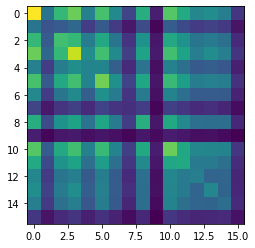

| feature extraction | train | ToyCar |:  12%|█▎        | 2/16 [00:01<00:13,  1.02it/s]

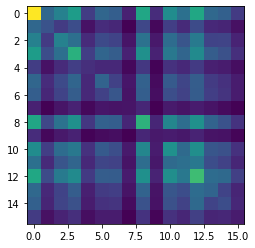

| feature extraction | train | ToyCar |:  19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]

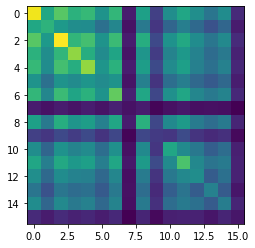

| feature extraction | train | ToyCar |:  25%|██▌       | 4/16 [00:03<00:09,  1.21it/s]

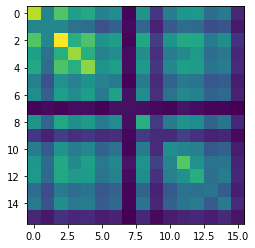

| feature extraction | train | ToyCar |:  31%|███▏      | 5/16 [00:04<00:09,  1.22it/s]

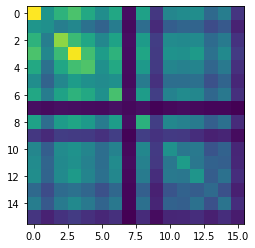

| feature extraction | train | ToyCar |:  38%|███▊      | 6/16 [00:05<00:07,  1.28it/s]

| feature extraction | train | ToyCar |:  44%|████▍     | 7/16 [00:05<00:06,  1.30it/s]

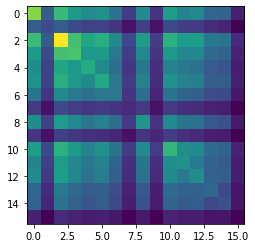

| feature extraction | train | ToyCar |:  50%|█████     | 8/16 [00:06<00:06,  1.31it/s]

| feature extraction | train | ToyCar |:  56%|█████▋    | 9/16 [00:07<00:05,  1.31it/s]

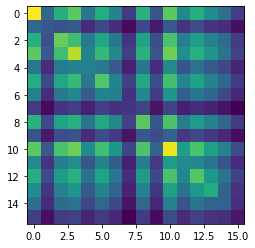

| feature extraction | train | ToyCar |:  62%|██████▎   | 10/16 [00:08<00:04,  1.31it/s]

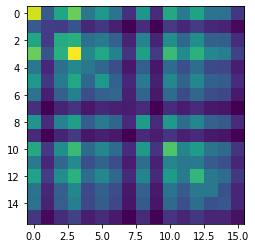

| feature extraction | train | ToyCar |:  69%|██████▉   | 11/16 [00:08<00:03,  1.33it/s]

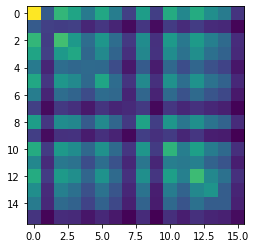

| feature extraction | train | ToyCar |:  75%|███████▌  | 12/16 [00:09<00:02,  1.35it/s]

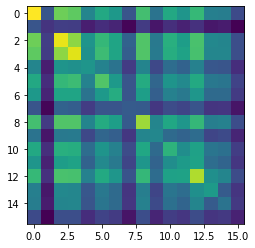

| feature extraction | train | ToyCar |:  81%|████████▏ | 13/16 [00:10<00:02,  1.34it/s]

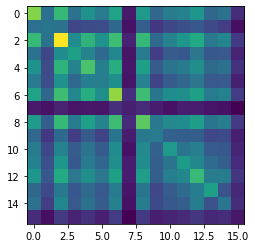

| feature extraction | train | ToyCar |:  88%|████████▊ | 14/16 [00:10<00:01,  1.33it/s]

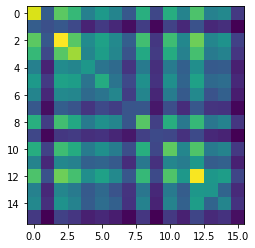

| feature extraction | train | ToyCar |:  94%|█████████▍| 15/16 [00:11<00:00,  1.32it/s]

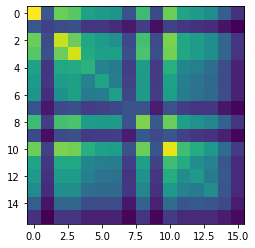

| feature extraction | train | ToyCar |: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]
| calc MVG | train | ToyCar |:  14%|█▍        | 37/256 [00:00<00:00, 364.96it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | ToyCar |: 100%|██████████| 256/256 [00:00<00:00, 411.32it/s]
| feature extraction | test | ToyCar |:   0%|          | 0/4 [00:00<?, ?it/s]

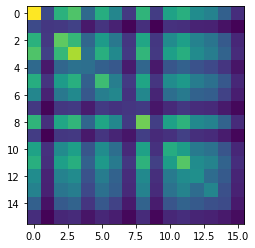

| feature extraction | test | ToyCar |:  25%|██▌       | 1/4 [00:01<00:05,  1.68s/it]

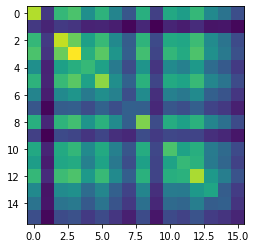

| feature extraction | test | ToyCar |:  50%|█████     | 2/4 [00:02<00:02,  1.14s/it]

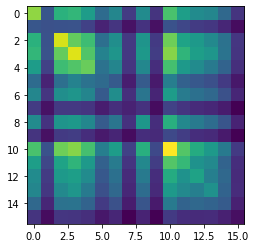

| feature extraction | test | ToyCar |:  75%|███████▌  | 3/4 [00:03<00:00,  1.04it/s]

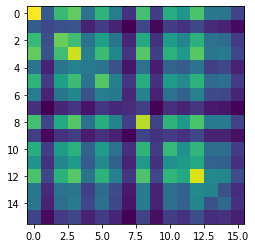

| feature extraction | test | ToyCar |: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
| calc mahalanobis | test | ToyCar |: 100%|██████████| 256/256 [00:01<00:00, 255.04it/s]
| plot heatmap | test | ToyCar |:   0%|          | 1/200 [00:00<00:35,  5.55it/s]

image ROCAUC: 0.813


| plot heatmap | test | ToyCar |: 100%|██████████| 200/200 [00:22<00:00,  8.90it/s]
| feature extraction | train | ToyTrain |:   0%|          | 0/16 [00:00<?, ?it/s]

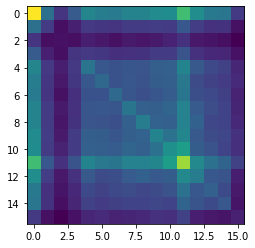

| feature extraction | train | ToyTrain |:   6%|▋         | 1/16 [00:02<00:35,  2.36s/it]

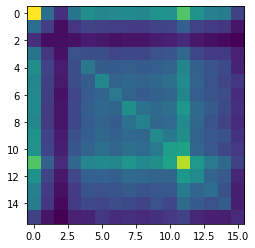

| feature extraction | train | ToyTrain |:  12%|█▎        | 2/16 [00:03<00:19,  1.39s/it]

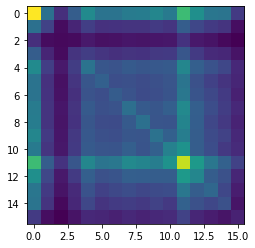

| feature extraction | train | ToyTrain |:  19%|█▉        | 3/16 [00:03<00:14,  1.08s/it]

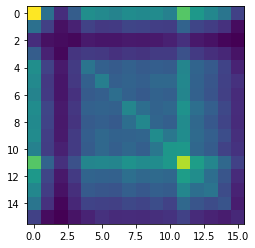

| feature extraction | train | ToyTrain |:  25%|██▌       | 4/16 [00:04<00:11,  1.08it/s]

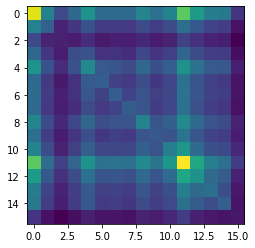

| feature extraction | train | ToyTrain |:  31%|███▏      | 5/16 [00:05<00:09,  1.17it/s]

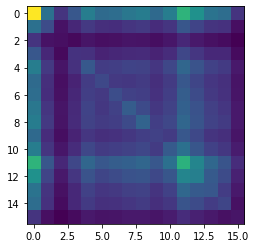

| feature extraction | train | ToyTrain |:  38%|███▊      | 6/16 [00:05<00:08,  1.22it/s]

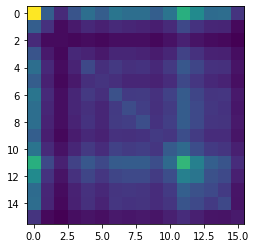

| feature extraction | train | ToyTrain |:  44%|████▍     | 7/16 [00:06<00:07,  1.26it/s]

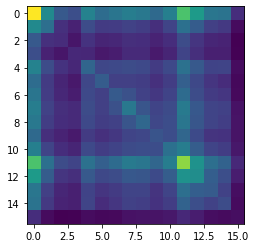

| feature extraction | train | ToyTrain |:  50%|█████     | 8/16 [00:08<00:08,  1.12s/it]

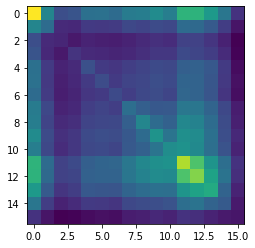

| feature extraction | train | ToyTrain |:  56%|█████▋    | 9/16 [00:09<00:06,  1.00it/s]

| feature extraction | train | ToyTrain |:  62%|██████▎   | 10/16 [00:10<00:05,  1.08it/s]

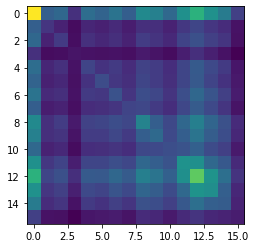

| feature extraction | train | ToyTrain |:  69%|██████▉   | 11/16 [00:10<00:04,  1.14it/s]

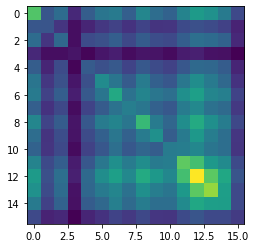

| feature extraction | train | ToyTrain |:  75%|███████▌  | 12/16 [00:11<00:03,  1.20it/s]

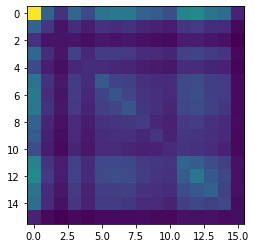

| feature extraction | train | ToyTrain |:  81%|████████▏ | 13/16 [00:12<00:02,  1.25it/s]

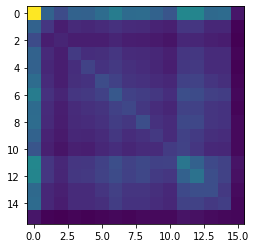

| feature extraction | train | ToyTrain |:  88%|████████▊ | 14/16 [00:12<00:01,  1.30it/s]

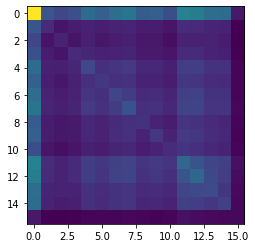

| feature extraction | train | ToyTrain |:  94%|█████████▍| 15/16 [00:13<00:00,  1.33it/s]

| feature extraction | train | ToyTrain |: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]
| calc MVG | train | ToyTrain |:  18%|█▊        | 47/256 [00:00<00:00, 461.54it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | ToyTrain |: 100%|██████████| 256/256 [00:00<00:00, 449.15it/s]
| feature extraction | test | ToyTrain |:   0%|          | 0/4 [00:00<?, ?it/s]

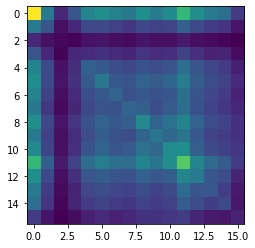

| feature extraction | test | ToyTrain |:  25%|██▌       | 1/4 [00:01<00:04,  1.67s/it]

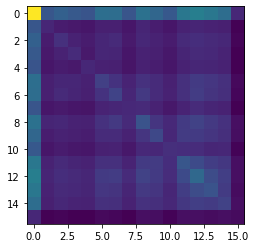

| feature extraction | test | ToyTrain |:  50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

| feature extraction | test | ToyTrain |:  75%|███████▌  | 3/4 [00:03<00:00,  1.09it/s]

| feature extraction | test | ToyTrain |: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
| calc mahalanobis | test | ToyTrain |: 100%|██████████| 256/256 [00:00<00:00, 293.13it/s]
| plot heatmap | test | ToyTrain |:   0%|          | 1/200 [00:00<00:21,  9.10it/s]

image ROCAUC: 0.777


| plot heatmap | test | ToyTrain |: 100%|██████████| 200/200 [00:21<00:00,  9.15it/s]
| feature extraction | train | fan |:   0%|          | 0/16 [00:00<?, ?it/s]

| feature extraction | train | fan |:   6%|▋         | 1/16 [00:01<00:24,  1.66s/it]

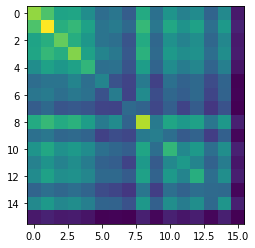

| feature extraction | train | fan |:  12%|█▎        | 2/16 [00:02<00:15,  1.09s/it]

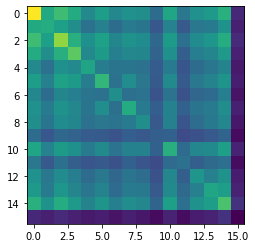

| feature extraction | train | fan |:  19%|█▉        | 3/16 [00:03<00:12,  1.08it/s]

| feature extraction | train | fan |:  25%|██▌       | 4/16 [00:03<00:10,  1.18it/s]

| feature extraction | train | fan |:  31%|███▏      | 5/16 [00:04<00:08,  1.23it/s]

| feature extraction | train | fan |:  38%|███▊      | 6/16 [00:05<00:08,  1.24it/s]

| feature extraction | train | fan |:  44%|████▍     | 7/16 [00:06<00:07,  1.26it/s]

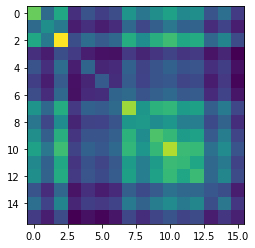

| feature extraction | train | fan |:  50%|█████     | 8/16 [00:06<00:06,  1.27it/s]

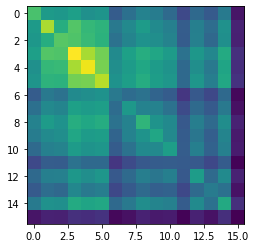

| feature extraction | train | fan |:  56%|█████▋    | 9/16 [00:07<00:05,  1.30it/s]

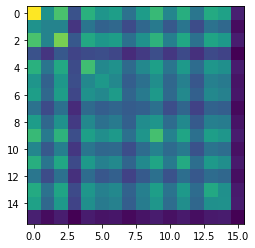

| feature extraction | train | fan |:  62%|██████▎   | 10/16 [00:08<00:04,  1.33it/s]

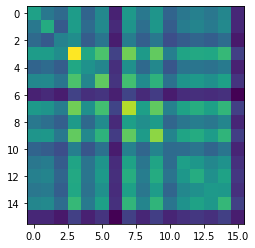

| feature extraction | train | fan |:  69%|██████▉   | 11/16 [00:09<00:03,  1.36it/s]

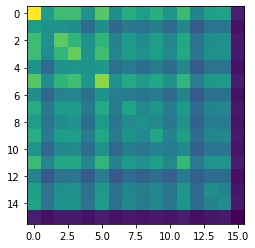

| feature extraction | train | fan |:  75%|███████▌  | 12/16 [00:09<00:02,  1.37it/s]

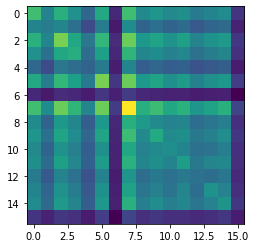

| feature extraction | train | fan |:  81%|████████▏ | 13/16 [00:10<00:02,  1.38it/s]

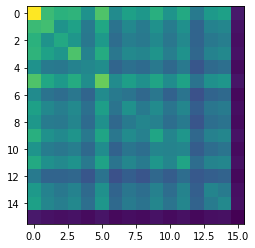

| feature extraction | train | fan |:  88%|████████▊ | 14/16 [00:11<00:01,  1.39it/s]

| feature extraction | train | fan |:  94%|█████████▍| 15/16 [00:11<00:00,  1.40it/s]

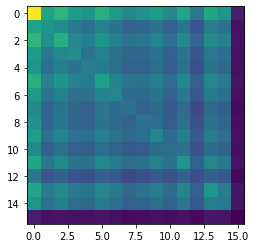

| feature extraction | train | fan |: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]
| calc MVG | train | fan |:  18%|█▊        | 46/256 [00:00<00:00, 457.25it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | fan |: 100%|██████████| 256/256 [00:00<00:00, 456.42it/s]
| feature extraction | test | fan |:   0%|          | 0/4 [00:00<?, ?it/s]

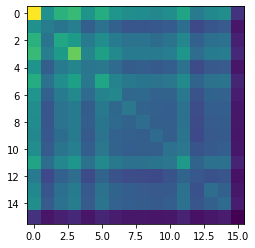

| feature extraction | test | fan |:  25%|██▌       | 1/4 [00:01<00:05,  1.69s/it]

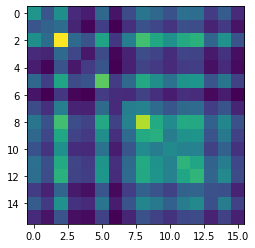

| feature extraction | test | fan |:  50%|█████     | 2/4 [00:02<00:02,  1.11s/it]

| feature extraction | test | fan |:  75%|███████▌  | 3/4 [00:03<00:00,  1.07it/s]

| feature extraction | test | fan |: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
| calc mahalanobis | test | fan |: 100%|██████████| 256/256 [00:00<00:00, 292.34it/s]
| plot heatmap | test | fan |:   0%|          | 1/200 [00:00<00:24,  8.27it/s]

image ROCAUC: 0.669


| plot heatmap | test | fan |: 100%|██████████| 200/200 [00:22<00:00,  8.87it/s]
| feature extraction | train | gearbox |:   0%|          | 0/16 [00:00<?, ?it/s]

| feature extraction | train | gearbox |:   6%|▋         | 1/16 [00:01<00:23,  1.59s/it]

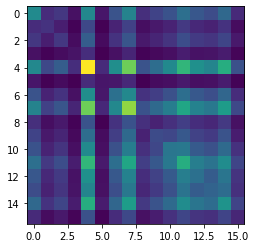

| feature extraction | train | gearbox |:  12%|█▎        | 2/16 [00:02<00:15,  1.08s/it]

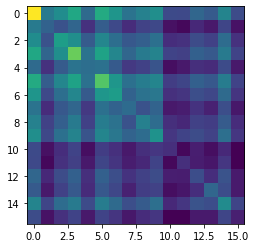

| feature extraction | train | gearbox |:  19%|█▉        | 3/16 [00:03<00:11,  1.09it/s]

| feature extraction | train | gearbox |:  25%|██▌       | 4/16 [00:03<00:09,  1.20it/s]

| feature extraction | train | gearbox |:  31%|███▏      | 5/16 [00:04<00:08,  1.24it/s]

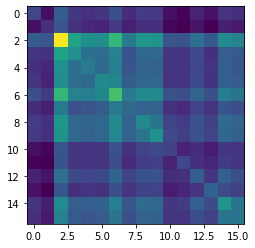

| feature extraction | train | gearbox |:  38%|███▊      | 6/16 [00:05<00:07,  1.27it/s]

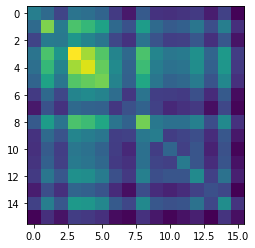

| feature extraction | train | gearbox |:  44%|████▍     | 7/16 [00:05<00:06,  1.32it/s]

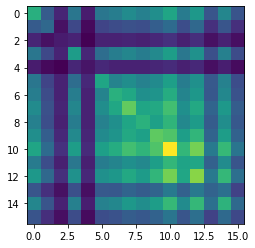

| feature extraction | train | gearbox |:  50%|█████     | 8/16 [00:06<00:05,  1.36it/s]

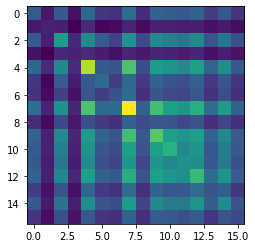

| feature extraction | train | gearbox |:  56%|█████▋    | 9/16 [00:07<00:05,  1.37it/s]

| feature extraction | train | gearbox |:  62%|██████▎   | 10/16 [00:08<00:04,  1.38it/s]

| feature extraction | train | gearbox |:  69%|██████▉   | 11/16 [00:08<00:03,  1.39it/s]

| feature extraction | train | gearbox |:  75%|███████▌  | 12/16 [00:09<00:02,  1.38it/s]

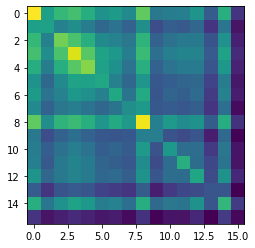

| feature extraction | train | gearbox |:  81%|████████▏ | 13/16 [00:10<00:02,  1.38it/s]

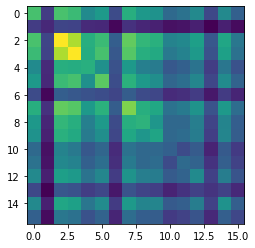

| feature extraction | train | gearbox |:  88%|████████▊ | 14/16 [00:10<00:01,  1.39it/s]

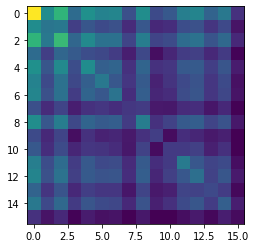

| feature extraction | train | gearbox |:  94%|█████████▍| 15/16 [00:11<00:00,  1.39it/s]

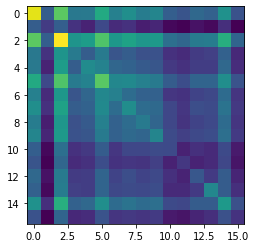

| feature extraction | train | gearbox |: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]
| calc MVG | train | gearbox |:  17%|█▋        | 43/256 [00:00<00:00, 423.29it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | gearbox |: 100%|██████████| 256/256 [00:00<00:00, 425.02it/s]
| feature extraction | test | gearbox |:   0%|          | 0/4 [00:00<?, ?it/s]

| feature extraction | test | gearbox |:  25%|██▌       | 1/4 [00:01<00:05,  1.71s/it]

| feature extraction | test | gearbox |:  50%|█████     | 2/4 [00:02<00:02,  1.13s/it]

| feature extraction | test | gearbox |:  75%|███████▌  | 3/4 [00:03<00:00,  1.06it/s]

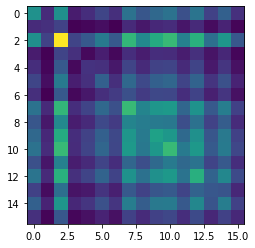

| feature extraction | test | gearbox |: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
| calc mahalanobis | test | gearbox |: 100%|██████████| 256/256 [00:00<00:00, 276.77it/s]
| plot heatmap | test | gearbox |:   0%|          | 1/200 [00:00<00:28,  6.93it/s]

image ROCAUC: 0.646


| plot heatmap | test | gearbox |: 100%|██████████| 200/200 [00:23<00:00,  8.34it/s]
| feature extraction | train | pump |:   0%|          | 0/16 [00:00<?, ?it/s]

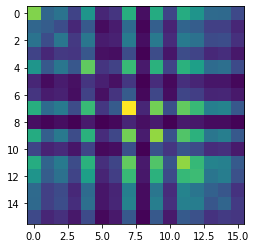

| feature extraction | train | pump |:   6%|▋         | 1/16 [00:01<00:23,  1.57s/it]

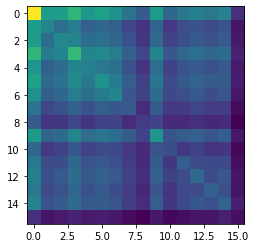

| feature extraction | train | pump |:  12%|█▎        | 2/16 [00:02<00:14,  1.06s/it]

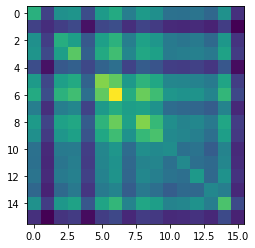

| feature extraction | train | pump |:  19%|█▉        | 3/16 [00:03<00:11,  1.10it/s]

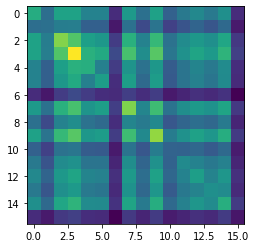

| feature extraction | train | pump |:  25%|██▌       | 4/16 [00:03<00:10,  1.18it/s]

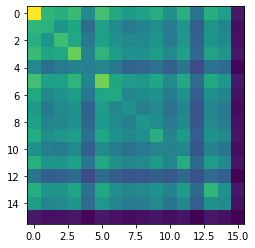

| feature extraction | train | pump |:  31%|███▏      | 5/16 [00:04<00:08,  1.24it/s]

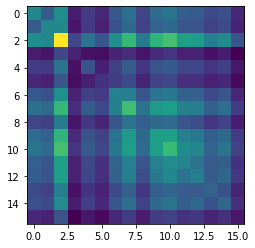

| feature extraction | train | pump |:  38%|███▊      | 6/16 [00:05<00:07,  1.30it/s]

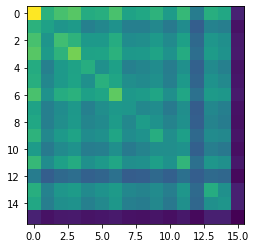

| feature extraction | train | pump |:  44%|████▍     | 7/16 [00:05<00:06,  1.33it/s]

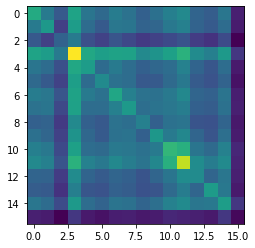

| feature extraction | train | pump |:  50%|█████     | 8/16 [00:06<00:05,  1.34it/s]

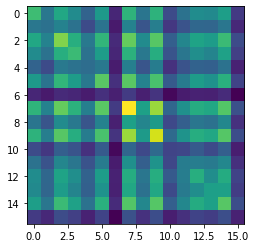

| feature extraction | train | pump |:  56%|█████▋    | 9/16 [00:07<00:05,  1.34it/s]

| feature extraction | train | pump |:  62%|██████▎   | 10/16 [00:08<00:04,  1.36it/s]

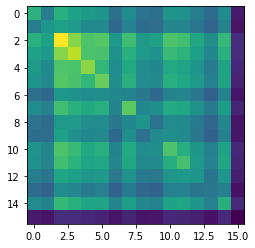

| feature extraction | train | pump |:  69%|██████▉   | 11/16 [00:08<00:03,  1.34it/s]

| feature extraction | train | pump |:  75%|███████▌  | 12/16 [00:09<00:03,  1.33it/s]

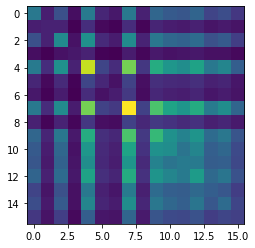

| feature extraction | train | pump |:  81%|████████▏ | 13/16 [00:10<00:02,  1.32it/s]

| feature extraction | train | pump |:  88%|████████▊ | 14/16 [00:11<00:01,  1.32it/s]

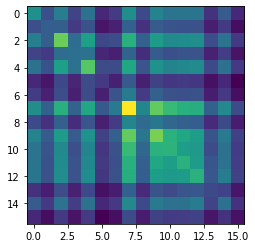

| feature extraction | train | pump |:  94%|█████████▍| 15/16 [00:11<00:00,  1.34it/s]

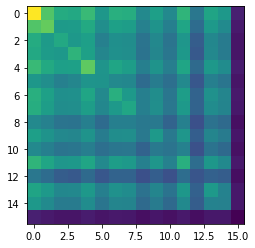

| feature extraction | train | pump |: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]
| calc MVG | train | pump |:  18%|█▊        | 47/256 [00:00<00:00, 462.17it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | pump |: 100%|██████████| 256/256 [00:00<00:00, 430.68it/s]
| feature extraction | test | pump |:   0%|          | 0/4 [00:00<?, ?it/s]

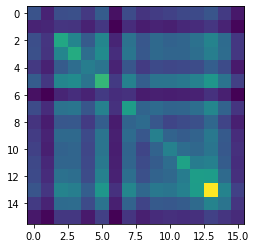

| feature extraction | test | pump |:  25%|██▌       | 1/4 [00:01<00:05,  1.67s/it]

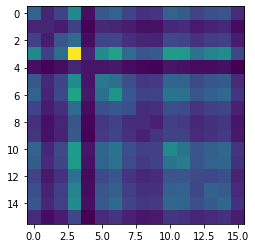

| feature extraction | test | pump |:  50%|█████     | 2/4 [00:02<00:02,  1.11s/it]

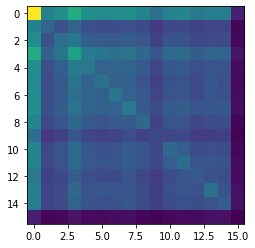

| feature extraction | test | pump |:  75%|███████▌  | 3/4 [00:03<00:00,  1.08it/s]

| feature extraction | test | pump |: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
| calc mahalanobis | test | pump |: 100%|██████████| 256/256 [00:00<00:00, 271.44it/s]
| plot heatmap | test | pump |:   0%|          | 1/200 [00:00<00:27,  7.19it/s]

image ROCAUC: 0.657


| plot heatmap | test | pump |: 100%|██████████| 200/200 [00:23<00:00,  8.36it/s]
| feature extraction | train | slider |:   0%|          | 0/16 [00:00<?, ?it/s]

| feature extraction | train | slider |:   6%|▋         | 1/16 [00:01<00:24,  1.66s/it]

| feature extraction | train | slider |:  12%|█▎        | 2/16 [00:03<00:24,  1.77s/it]

| feature extraction | train | slider |:  19%|█▉        | 3/16 [00:04<00:17,  1.31s/it]

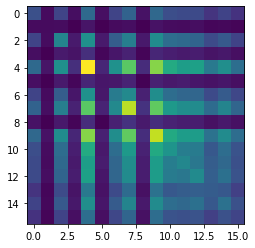

| feature extraction | train | slider |:  25%|██▌       | 4/16 [00:04<00:12,  1.08s/it]

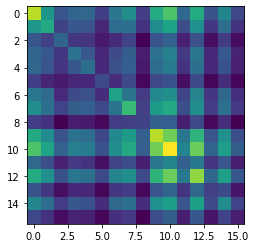

| feature extraction | train | slider |:  31%|███▏      | 5/16 [00:05<00:10,  1.06it/s]

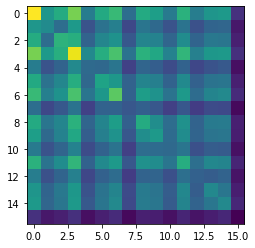

| feature extraction | train | slider |:  38%|███▊      | 6/16 [00:06<00:08,  1.15it/s]

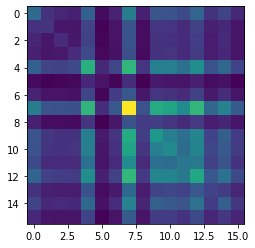

| feature extraction | train | slider |:  44%|████▍     | 7/16 [00:07<00:07,  1.22it/s]

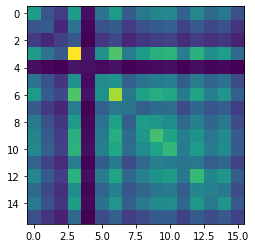

| feature extraction | train | slider |:  50%|█████     | 8/16 [00:07<00:06,  1.25it/s]

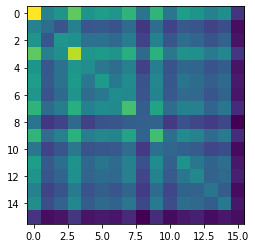

| feature extraction | train | slider |:  56%|█████▋    | 9/16 [00:08<00:05,  1.29it/s]

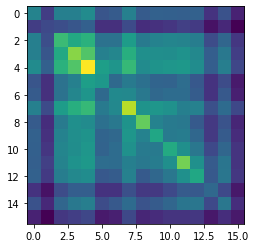

| feature extraction | train | slider |:  62%|██████▎   | 10/16 [00:09<00:04,  1.32it/s]

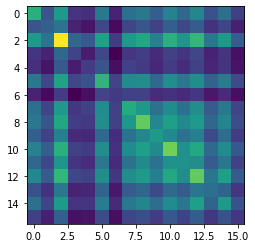

| feature extraction | train | slider |:  69%|██████▉   | 11/16 [00:10<00:03,  1.33it/s]

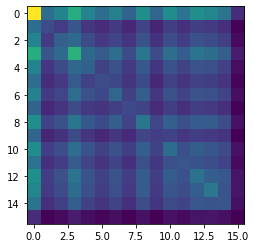

| feature extraction | train | slider |:  75%|███████▌  | 12/16 [00:10<00:02,  1.34it/s]

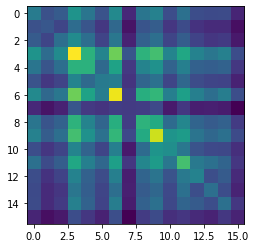

| feature extraction | train | slider |:  81%|████████▏ | 13/16 [00:11<00:02,  1.33it/s]

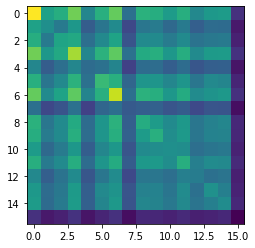

| feature extraction | train | slider |:  88%|████████▊ | 14/16 [00:12<00:01,  1.31it/s]

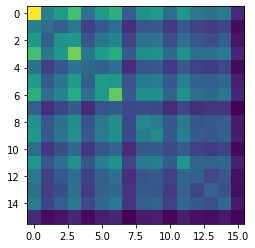

| feature extraction | train | slider |:  94%|█████████▍| 15/16 [00:13<00:00,  1.32it/s]

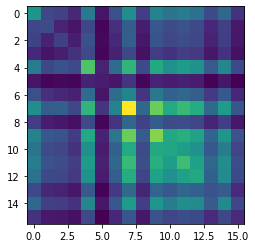

| feature extraction | train | slider |: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]
| calc MVG | train | slider |:  18%|█▊        | 45/256 [00:00<00:00, 446.50it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | slider |: 100%|██████████| 256/256 [00:00<00:00, 445.12it/s]
| feature extraction | test | slider |:   0%|          | 0/4 [00:00<?, ?it/s]

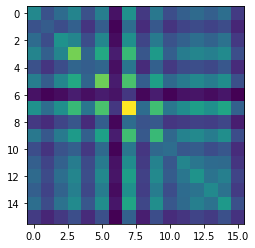

| feature extraction | test | slider |:  25%|██▌       | 1/4 [00:01<00:05,  1.73s/it]

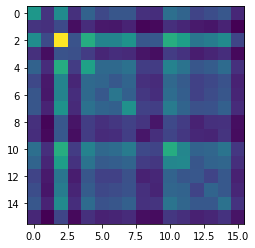

| feature extraction | test | slider |:  50%|█████     | 2/4 [00:02<00:02,  1.13s/it]

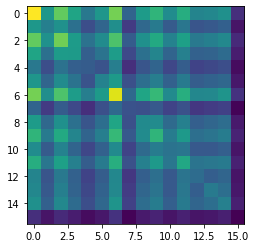

| feature extraction | test | slider |:  75%|███████▌  | 3/4 [00:03<00:00,  1.05it/s]

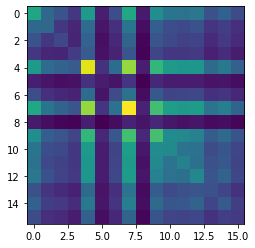

| feature extraction | test | slider |: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
| calc mahalanobis | test | slider |: 100%|██████████| 256/256 [00:00<00:00, 299.56it/s]
| plot heatmap | test | slider |:   1%|          | 2/200 [00:00<00:19, 10.37it/s]

image ROCAUC: 0.670


| plot heatmap | test | slider |: 100%|██████████| 200/200 [00:21<00:00,  9.40it/s]
| feature extraction | train | valve |:   0%|          | 0/16 [00:00<?, ?it/s]

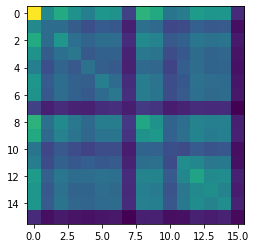

| feature extraction | train | valve |:   6%|▋         | 1/16 [00:01<00:26,  1.79s/it]

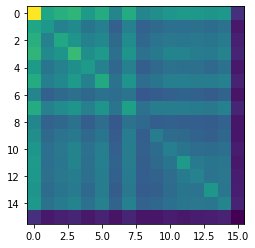

| feature extraction | train | valve |:  12%|█▎        | 2/16 [00:02<00:16,  1.15s/it]

| feature extraction | train | valve |:  19%|█▉        | 3/16 [00:03<00:12,  1.03it/s]

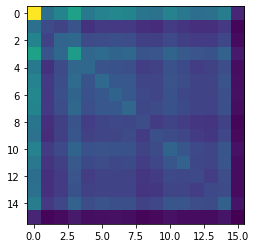

| feature extraction | train | valve |:  25%|██▌       | 4/16 [00:03<00:10,  1.14it/s]

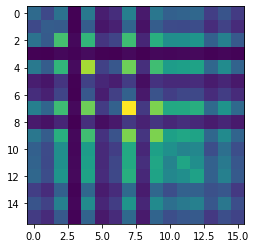

| feature extraction | train | valve |:  31%|███▏      | 5/16 [00:04<00:08,  1.22it/s]

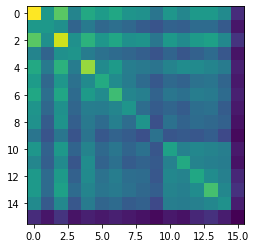

| feature extraction | train | valve |:  38%|███▊      | 6/16 [00:05<00:07,  1.29it/s]

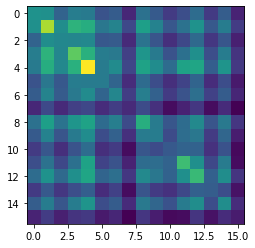

| feature extraction | train | valve |:  44%|████▍     | 7/16 [00:06<00:06,  1.33it/s]

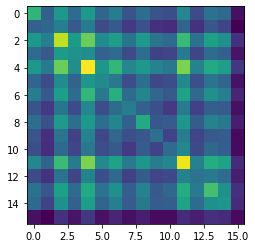

| feature extraction | train | valve |:  50%|█████     | 8/16 [00:06<00:05,  1.34it/s]

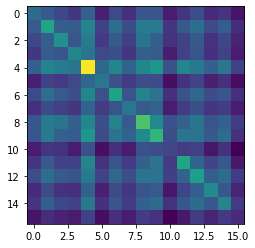

| feature extraction | train | valve |:  56%|█████▋    | 9/16 [00:07<00:05,  1.37it/s]

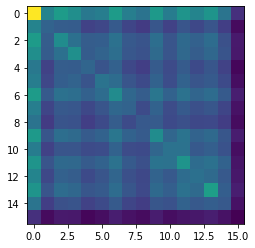

| feature extraction | train | valve |:  62%|██████▎   | 10/16 [00:08<00:04,  1.38it/s]

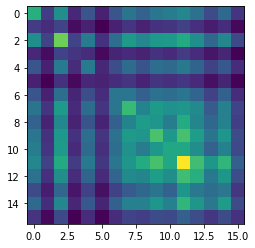

| feature extraction | train | valve |:  69%|██████▉   | 11/16 [00:09<00:05,  1.02s/it]

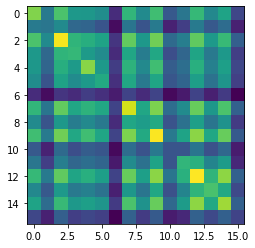

| feature extraction | train | valve |:  75%|███████▌  | 12/16 [00:10<00:03,  1.08it/s]

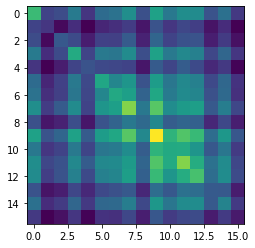

| feature extraction | train | valve |:  81%|████████▏ | 13/16 [00:11<00:02,  1.16it/s]

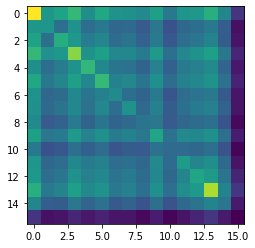

| feature extraction | train | valve |:  88%|████████▊ | 14/16 [00:12<00:01,  1.23it/s]

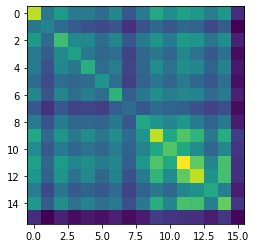

| feature extraction | train | valve |:  94%|█████████▍| 15/16 [00:12<00:00,  1.28it/s]

| feature extraction | train | valve |: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]
| calc MVG | train | valve |:  18%|█▊        | 46/256 [00:00<00:00, 451.39it/s]

torch.Size([1000, 128, 16, 16])


| calc MVG | train | valve |: 100%|██████████| 256/256 [00:00<00:00, 466.42it/s]
| feature extraction | test | valve |:   0%|          | 0/4 [00:00<?, ?it/s]

| feature extraction | test | valve |:  25%|██▌       | 1/4 [00:01<00:05,  1.84s/it]

| feature extraction | test | valve |:  50%|█████     | 2/4 [00:02<00:02,  1.18s/it]

| feature extraction | test | valve |:  75%|███████▌  | 3/4 [00:03<00:00,  1.03it/s]

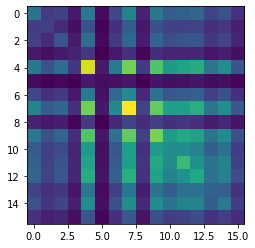

| feature extraction | test | valve |: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
| calc mahalanobis | test | valve |: 100%|██████████| 256/256 [00:00<00:00, 259.91it/s]
| plot heatmap | test | valve |:   0%|          | 1/200 [00:00<00:30,  6.53it/s]

image ROCAUC: 0.569


| plot heatmap | test | valve |: 100%|██████████| 200/200 [00:22<00:00,  8.86it/s]
/home/hiroki/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hiroki/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


Average ROCAUC: 0.686
Average pixel ROCUAC: nan


In [10]:
main()